# 자전거 수요 예측(Kaggle)

>Kaggle에서 진행했던 자전거 수요에측 경진대회에 도전해보기로 합니다.  
본 포스팅은 오늘의코드 페이지를 운영하는 **corazzon**님의 포스팅을 참고하여 제작하였습니다.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings(action='ignore') 

# 노트북 안에 그래프 그리기
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus'] = False

# 그래프에서 한글 폰트 깨지는 문제 해결 : 나눔고딕 사용
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 10

# 서브 plot의 여백 조정(현재 조정안됨)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
plt.tight_layout()

<hr/>
## 1. 데이터 불러오기

In [2]:
train_path = "data/train.csv"
test_path = "data/test.csv"

train = pd.read_csv(train_path, parse_dates = ["datetime"])
test = pd.read_csv(test_path, parse_dates = ['datetime'])

train.shape

(10886, 12)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null datetime64[ns]
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.6 KB


### * 변수에 대한 설명

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields

**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
**holiday** - whether the day is considered a holiday  
**workingday** - whether the day is neither a weekend nor holiday  
**weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
**temp** - temperature in Celsius  
**atemp** - "feels like" temperature in Celsius  
**humidity** - relative humidity  
**windspeed** - wind speed  
**casual** - number of non-registered user rentals initiated  
**registered** - number of registered user rentals initiated  
**count** - number of total rentals  

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

결측값이 없는 잘 정제된 데이터임을 확인

## 2. 탐색적 자료분석(EDA)

### 2.1 datetime

시계열 데이터는 시간에 따른 변화를 살펴보는것이 중요하다고 판단.  
연도, 월, 일, 시, 요일 별로 나누어 시각화 만들기.

In [7]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 17)

[Text(0.5,0,'workingday'), Text(0.5,1,'근무일 대여량')]

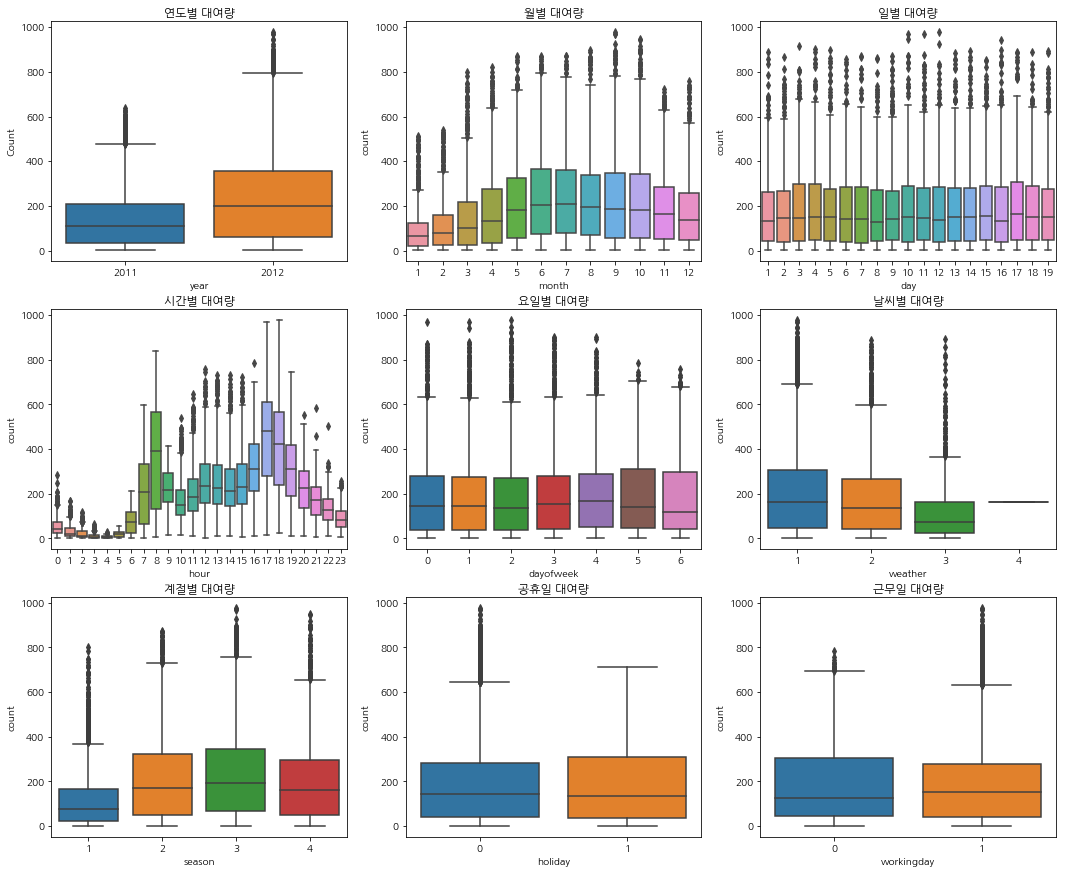

In [8]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3)
figure.set_size_inches(18,15)

sns.boxplot(data=train, x="year", y="count", ax=ax1)
sns.boxplot(data=train, x="month", y="count", ax=ax2)
sns.boxplot(data=train, x="day", y="count", ax=ax3)
sns.boxplot(data=train, x="hour", y="count", ax=ax4)
sns.boxplot(data=train, x="dayofweek", y="count", ax=ax5)
sns.boxplot(data=train, x="weather", y="count", ax=ax6)
sns.boxplot(data=train, x="season", y="count", ax=ax7)
sns.boxplot(data=train, x="holiday", y="count", ax=ax8)
sns.boxplot(data=train, x="workingday", y="count", ax=ax9)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")
ax5.set(xlabel='dayofweek', title="요일별 대여량")
ax6.set(xlabel='weather', title="날씨별 대여량")
ax7.set(xlabel='season', title="계절별 대여량")
ax8.set(xlabel='holiday', title="공휴일 대여량")
ax9.set(xlabel='workingday', title="근무일 대여량")

##### Insight


1. 2011년도에 비해 2012년도의 대여량이 증가(시간에 Depand 되어있음).
2. 월별로는 6월이 가장 대여량이 많고, 1월이 가장 적음.
3. 일별 대여량에는 큰 차이가 없음.
4. 시간별로는 출근,퇴근 시간에 대여량이 증가함.
5. 요일별 대여량에도 큰 차이가 없음.
6. 날씨별 대여량에는 맑은 날씨일때가 가장 높고, 강한비 일때는 가장 적음.
7. 계절별 대여량에서는 봄에 대여량이 적고 가을에 가장 많음.
8. 공휴일에 따른 대여량에 차이가 없음.
9. 근무일에 따른 대여량에 차이가 없음.

### 2.2 시간별 근무일, 요일, 날씨, 계절별, 등록유무별 대여량 확인

자전거 대여량에 많은 요인을 준다고 판단되는 근무유무, 요일, 날씨, 계절, 기후요소에 대하여 시간의 흐름에 따른 확인이 필요.

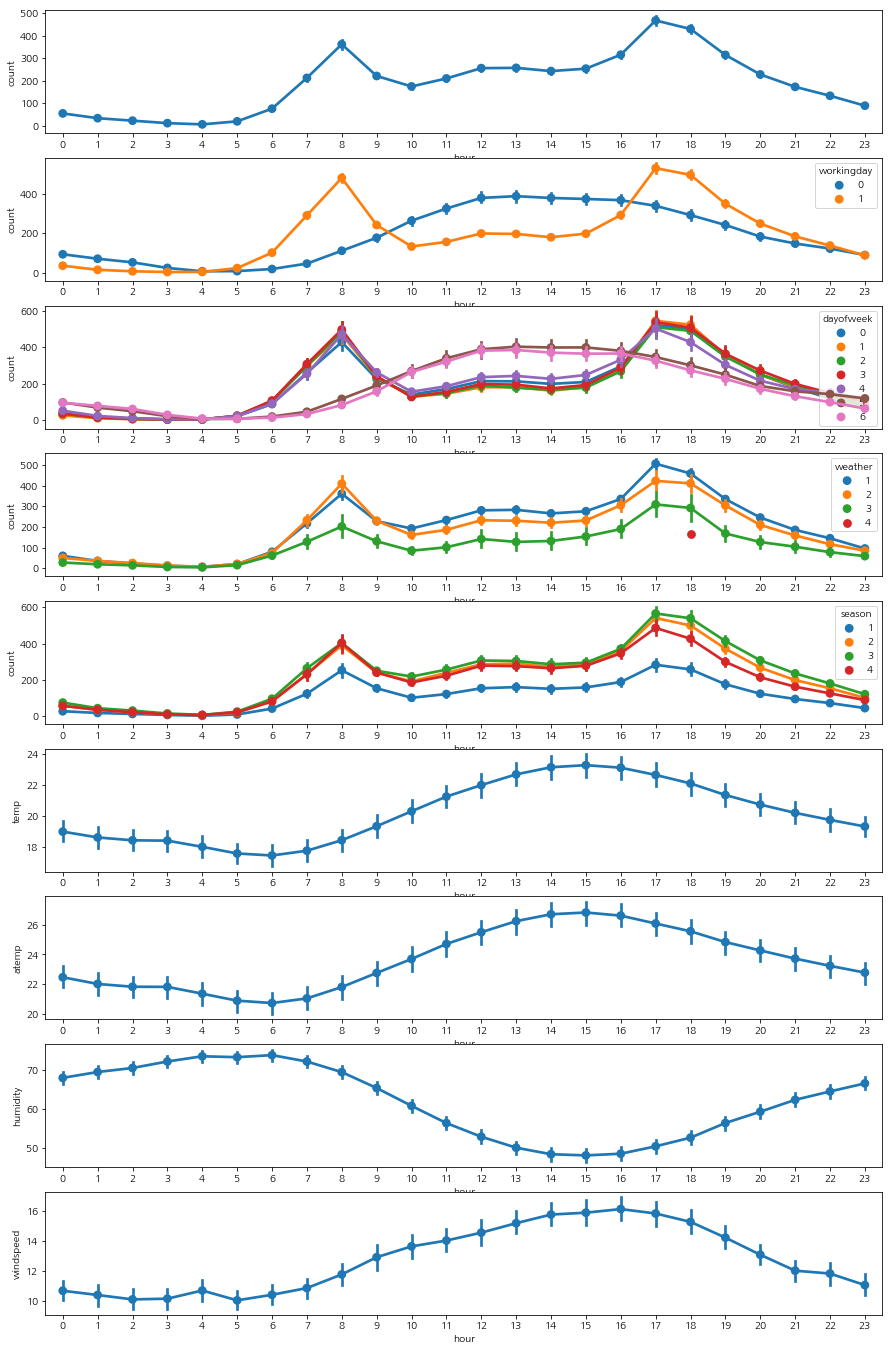

In [9]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows = 9)
fig.set_size_inches(15,24)

sns.pointplot(data = train, x = "hour", y = "count", ax = ax1)
sns.pointplot(data = train, x = "hour", y = "count", hue = "workingday", ax = ax2)
sns.pointplot(data = train, x = "hour", y = "count", hue = "dayofweek", ax = ax3)
sns.pointplot(data = train, x = "hour", y = "count", hue = "weather", ax = ax4)
sns.pointplot(data = train, x = "hour", y = "count", hue = "season", ax = ax5)
sns.pointplot(data = train, x = "hour", y = "temp", ax = ax6)
sns.pointplot(data = train, x = "hour", y = "atemp", ax = ax7)
sns.pointplot(data = train, x = "hour", y = "humidity", ax = ax8)
sns.pointplot(data = train, x = "hour", y = "windspeed", ax = ax9)

##### Insight

1. 시간별 대여량은 출퇴근 시간에 증가.
2. 근무일에는 출퇴근 시간에 증가하나, 근무일이 아닌날에는 점심시간에 증가하는 추세.
3. 평일에는 출퇴근 시간에 증가하나, 토요일 일요일과 같이 휴일에는 점심시간에 증가하는 추세.
4. dayofweek / holiday의 대여량 패턴이 유사하기 때문에 두 변수중 하나만 사용하는것이 좋아보임.
5. 날씨가 나쁠수록 대여량이 전체적으로 감소. 시간별로 날씨에 따른 대여량의 추세에는 영향을 미치지 않음.  
   (4에 해당하는 Heavy Rain은 적절한 처리를 하는것이 좋을것으로 판단됨)
6. 봄에 가장 대여량이 적고 가을에 가장 높음. 시간별로 계절에 따른 대여량의 추세에는 영향을 미치지 않음.
7. 기후요소에 대해서는 습도는 낮시간에 떨어지고, 풍속은 증가하는것을 확인.

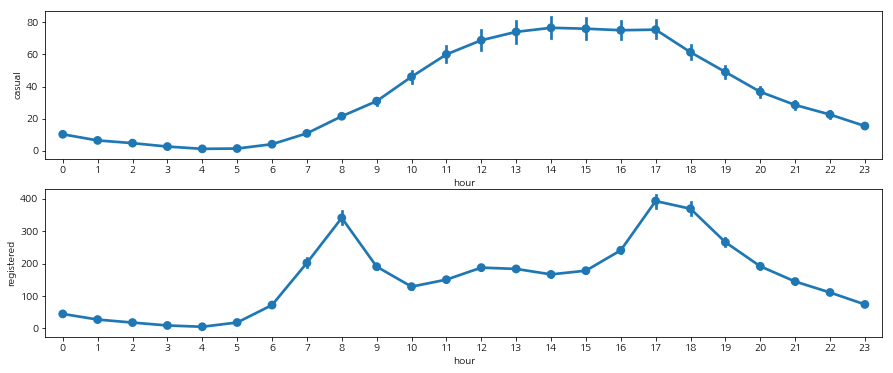

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows = 2)
fig.set_size_inches(15,6)

sns.pointplot(data = train, x = "hour", y = "casual", ax = ax1)
sns.pointplot(data = train, x = "hour", y = "registered", ax = ax2)

##### insigh

1. 등록유무에 따라서 대여량에 차이가 있음을 확인.
2. ***비등록, 등록에 따라 각각 예측모델링을 만들어 합계를 내는것이 타당하다고 봄.***

### 2.3 온도, 체감온도, 습도, 풍속

기온과 관련된 변수에 어떠한 관계가 있는지 살펴보기.

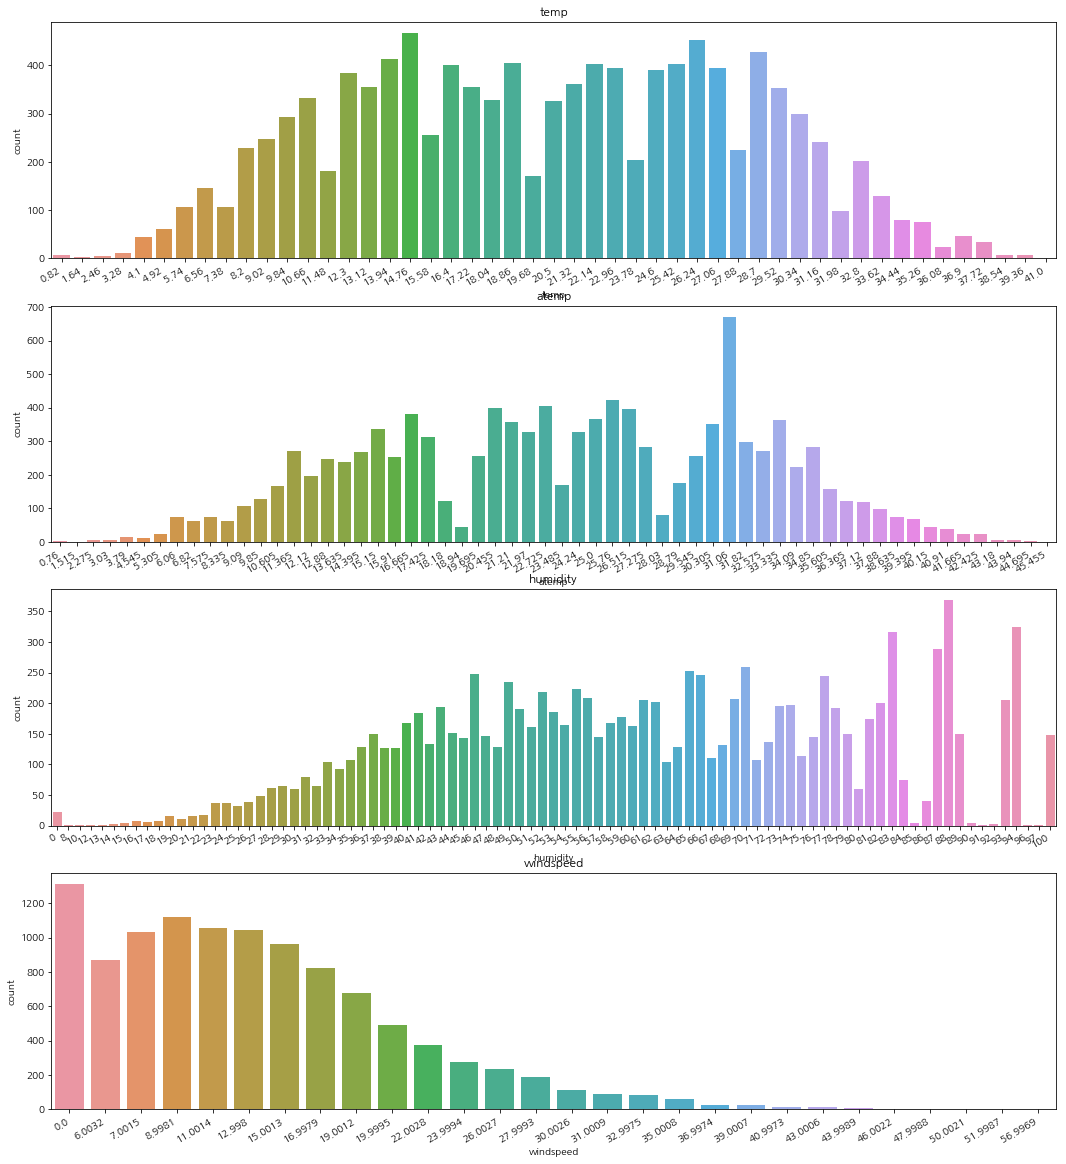

In [11]:
fig, axes = plt.subplots(nrows = 4)
fig.set_size_inches(18,20)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="temp")
sns.countplot(data=train, x="temp", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="atemp")
sns.countplot(data=train, x="atemp", ax=axes[1])

plt.sca(axes[2])
plt.xticks(rotation=30, ha='right')
axes[2].set(ylabel='Count',title="humidity")
sns.countplot(data=train, x="humidity", ax=axes[2])

plt.sca(axes[3])
plt.xticks(rotation=30, ha='right')
axes[3].set(ylabel='Count',title="windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[3])

In [12]:
# 기후요소간 상관관계 알아보기
corrMatt = train[["temp", "atemp", "humidity", "windspeed", "casual", "registered","count"]]
corrMatt = corrMatt.corr()
print(round(corrMatt, 3))

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

             temp  atemp  humidity  windspeed  casual  registered  count
temp        1.000  0.985    -0.065     -0.018   0.467       0.319  0.394
atemp       0.985  1.000    -0.044     -0.057   0.462       0.315  0.390
humidity   -0.065 -0.044     1.000     -0.319  -0.348      -0.265 -0.317
windspeed  -0.018 -0.057    -0.319      1.000   0.092       0.091  0.101
casual      0.467  0.462    -0.348      0.092   1.000       0.497  0.690
registered  0.319  0.315    -0.265      0.091   0.497       1.000  0.971
count       0.394  0.390    -0.317      0.101   0.690       0.971  1.000


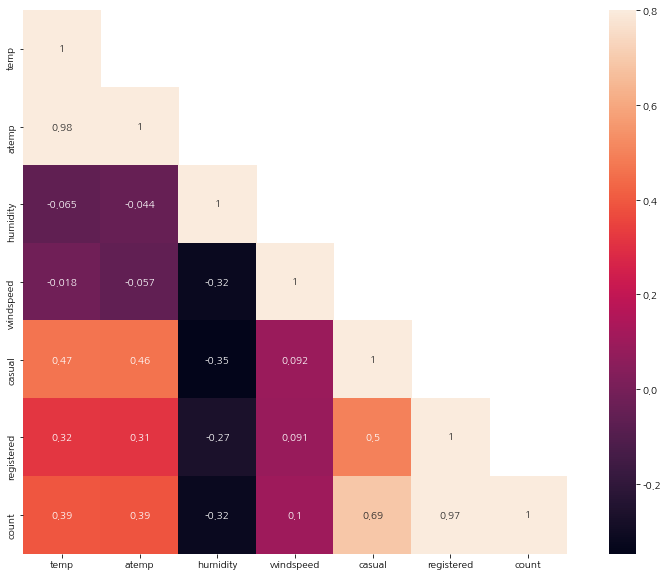

In [13]:
# 히트맵으로 시각화
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(corrMatt, mask = mask, vmax = 0.8, square = True, annot = True)

##### insight

1. 온도와 체감온도 사이에는 높은 상관관계 -> 두 변수중 한가지만 사용하는것이 좋을것 같음.
2. 풍속이 0인 데이터는 있는것으로 보아 결측값으로 판단하는게 합리적.

### 2.4 target variable 분포 파악

count, casual, registered의 분포를 파악해야 어떠한 모델이 적합한지 판단할 수 있음.

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1,   1,   1, ..., 968, 970, 977], dtype=int64)),
 (169.82942673231383, 191.5741319125482, 0.9372682766213174))

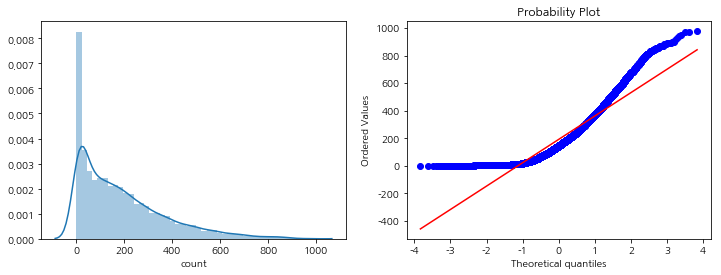

In [14]:
# count값의 데이터 분포도를 파악

fig, axes = plt.subplots(ncols = 2)
fig.set_size_inches(12, 4)

sns.distplot(train["count"], ax = axes[0])
stats.probplot(train["count"], dist = "norm", fit = True, plot = axes[1])

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  0,   0,   0, ..., 361, 362, 367], dtype=int64)),
 (41.978306837190885, 36.021954804335834, 0.8399904742683888))

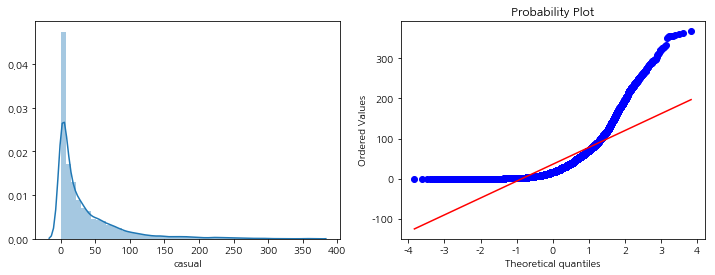

In [15]:
# casual값의 데이터 분포도를 파악

fig, axes = plt.subplots(ncols = 2)
fig.set_size_inches(12, 4)

sns.distplot(train["casual"], ax = axes[0])
stats.probplot(train["casual"], dist = "norm", fit = True, plot = axes[1])

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  0,   0,   0, ..., 857, 857, 886], dtype=int64)),
 (139.81014426731886, 155.55217710821236, 0.9253914934898901))

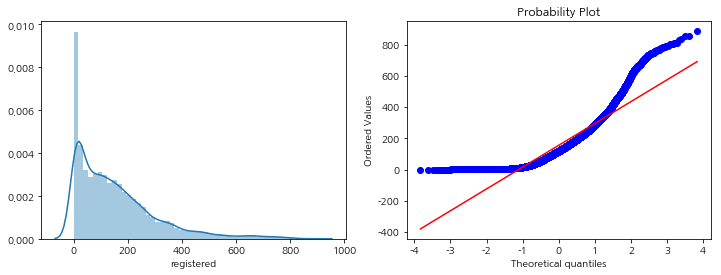

In [16]:
# registered값의 데이터 분포도를 파악

fig, axes = plt.subplots(ncols = 2)
fig.set_size_inches(12, 4)

sns.distplot(train["registered"], ax = axes[0])
stats.probplot(train["registered"], dist = "norm", fit = True, plot = axes[1])

##### insight

1. 심야시간에는 대여량이 없는경우가 많기 때문에 데이터가 모두 왼쪽으로 치우친 모습.
2. Linear Regression 기법을 사용하기에는 적합하지 않으므로 ***Random Forest, XGBoost*** 등을 이용.

## 3. Feature Engineering

탐색적 데이터분석(EDA) 결과 아래와 같이 변수를 전처리할 필요가 있어보임.  
train set 뿐만아니라 test set에서도 동일하게 처리를 해주어야함.

> 1. 대여량은 시간별로 큰 차이를 보이므로 분석단위는 시간으로 할것.
> 2. casual, registered로 나누어 모델링.
> 3. 날씨변수에서 4번카테고리(heavy rain) 처리하기.
> 4. 풍속에 대한 결측값(0) 처리하기.
> 5. 온도, 체감온도 중 한개의 변수만 사용하기.

### 3.1 시간변수 만들기

train set은 탐색적 자료분석을 하는 과정에서 생성하였음.  
test set에서도 생성.

In [17]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 14)

### 3.2 target variable 나누기

이미 나누어져있으므로 전처리 필요없음.

### 3.3 날씨변수 4번 카테고리 처리하기.

In [18]:
train['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

4번 카테고리(heavy rain)의 값이 1개이므로 이를 카테고리 값으로 대체가 필요.  
3번 카테고리(Light rain)의 값으로 변환.

In [19]:
train['weather'] = train['weather'].replace(to_replace = 4, value = 3)
train['weather'].value_counts()

1    7192
2    2834
3     860
Name: weather, dtype: int64

In [20]:
test['weather'].value_counts()

1    4221
2    1710
3     560
4       2
Name: weather, dtype: int64

In [21]:
test['weather'] = test['weather'].replace(to_replace = 4, value = 3)
test['weather'].value_counts()

1    4221
2    1710
3     562
Name: weather, dtype: int64

### 3.4 풍속에 대한 결측값(0) 처리하기

결측값이라 판단되는 값(풍속=0) 또한 다른값으로 대체해야함.  
평균, 최빈값 등으로 대체할 수 있겠으나 기후요소는 대여량에 영향을 미치는 중요변수로 판단되므로 이와같은 방법을 사용하기 부적절함.  
따라서 풍속을 target으로 하여 Random Forest로 예측하여 값을 넣는 방법을 사용.  
풍속에 대해서도 모델링을 하는것이기에 모델평가를 해야하지만... 이렇게까지 해야하나 싶음.

In [22]:
# train set, test set 합치기

wind = pd.concat([train, test], axis = 0)
wind = wind.sort_values(by = 'datetime')
wind = wind[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek']]

# 풍속 0인것과 0이 아닌것 분류
zero_wind = wind[wind['windspeed'] == 0]
notzero_wind = wind[wind['windspeed'] != 0]

# 풍속 예측에 사용된 예측변수들
X_feature = ['season','weather','temp','humidity','month','hour']

# windspeed의 변수타입을 str롤 변환(windspeed가 연속형으로 보기에 적합하지 않다고 판단.)
notzero_wind.loc[:, "windspeed"] = notzero_wind.loc[:, "windspeed"].astype("str")

# 모델 적합
modelfit = RandomForestClassifier().fit(notzero_wind[X_feature], notzero_wind['windspeed'])

# 예측
pre_wind = modelfit.predict(X = zero_wind[X_feature])
zero_wind.loc[:, "windspeed"] = pre_wind

# # zero_wind와 notzero_wind 합치고 재정렬
wind = notzero_wind.append(zero_wind)
wind.loc[:, 'windspeed'] = wind.loc[:, 'windspeed'].astype(np.float64)
wind = wind.sort_values(by = 'datetime')

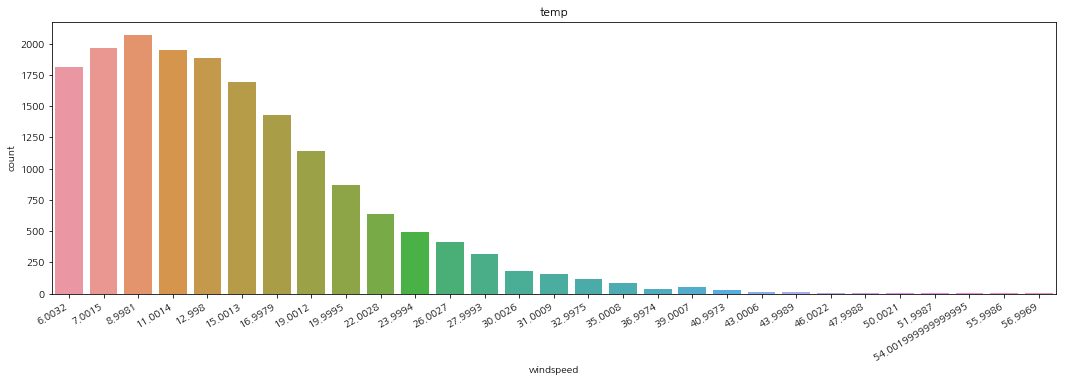

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(18,5)

plt.xticks(rotation=30, ha='right')
ax.set(ylabel='Count',title="temp")
sns.countplot(data=wind, x="windspeed")

In [24]:
# 합친 데이터를 train set, test set으로 다시 분할

train = wind[wind['datetime'].isin(train['datetime'])]
test = wind[wind['datetime'].isin(test['datetime'])]

### 3.5 온도, 체감온도중 한개의 변수만 사용하기

상관관계가 매우 높기때문에 어떤것을 사용해도 무방해보임.  
각 변수를 번갈아가면서 모델링하여 예측률이 더 높은 변수를 사용.

##  4. Modeling(RandomForest)

사용할 변수  
> year, month, dayofweek, workingday, holiday, hour, season, weather, temp(또는 atemp), humidity, windspeed

우선 RandomForest에 모든 변수를 넣은 후 변수중요도(Impurity)를 확인한 후 중요하지 않은것 부터 하나씩 제거하며 모델링을 시작.  
최종적으로 holiday만 제거하니 가장 퍼포먼스가 좋음.

In [25]:
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train.loc[:, var] = train.loc[:, var].astype("category")
    test.loc[:, var] = test.loc[:, var].astype("category")
    
X = ['year','month','dayofweek','workingday','hour','season','weather','temp','humidity','windspeed']

In [26]:
# train, test 7:3 분할
x_train, x_test, y_train, y_test = train_test_split(train[X], np.array(train[['registered','casual']]),
                                                    test_size = 0.3, random_state = 100)
y_train = pd.DataFrame(y_train, columns = ['registered','casual'])
y_test = pd.DataFrame(y_test, columns = ['registered','casual'])

# registered에 대하여 fitting
fit_registered = RandomForestRegressor().fit(x_train, y_train['registered'])
pre_registered = fit_registered.predict(x_test)

# casual에 대하여 fitting
fit_casual = RandomForestRegressor().fit(x_train, y_train['casual'])
pre_casual = fit_casual.predict(x_test)

# 실제 test data에 매칭
registered = fit_registered.predict(test[X])
test['registered'] = np.rint(registered) # 소수발생 시 반올림

casual = fit_casual.predict(test[X])
test['casual'] = np.rint(casual) # 소수발생 시 반올림

test['count'] = test['registered'] + test['casual']

# RMSLE

pre_count = pre_registered + pre_casual
y_test_count = y_test['registered'] + y_test['casual']

diff = np.log(pre_count + 1) - np.log(y_test_count + 1)

score = np.sqrt(np.square(diff).mean())
print("Score = {0:5f}".format(score))

Score = 0.339976


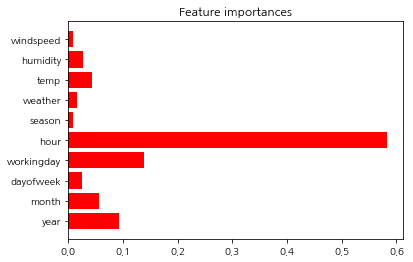

In [27]:
importance = fit_registered.feature_importances_

plt.title("Feature importances")
plt.barh(range(train[X].shape[1]), importance, color="r", align="center")
plt.yticks(np.arange(train[X].shape[1]), X)
plt.show()

***XGBoost도 시도하보려 했으나 패키지 설치에 문제 발생***


## 5. Submission

Kaggle에 제출할 파일 생성.

In [28]:
path = "data\\sampleSubmission.csv"
submission = pd.read_csv(path)

submission['count'] = test['registered'] + test['casual']
submission.head()

,datetime,count
0,2011-01-20 00:00:00,13.0
1,2011-01-20 01:00:00,6.0
2,2011-01-20 02:00:00,3.0
3,2011-01-20 03:00:00,2.0
4,2011-01-20 04:00:00,2.0


In [29]:
submission.to_csv("data\\Score_{0:5f}_submission.csv".format(score),index = False)

해당 CSV 파일을 Kaggle에 submission 하였다.  
Score 0.474로 전체참가자 3251명중 약 1100등(상위 33%) 정도를 기록하였다.  
다양한 모델링기법이나 ReSampling 방법을 사용한다면 조금 더 좋은 점수를 받을 수 있을것이라 생각된다.

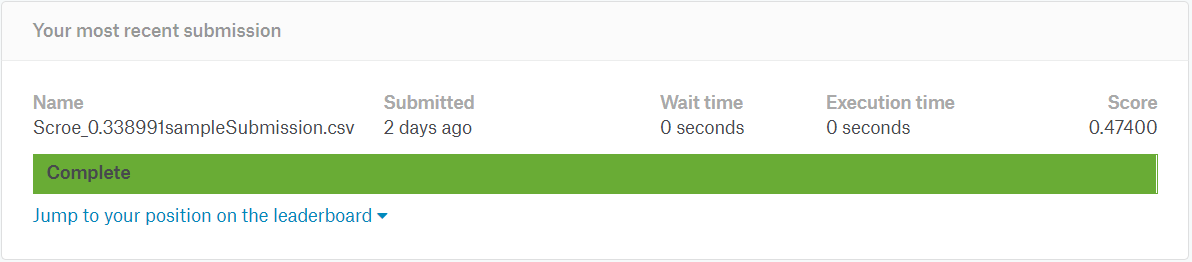

In [30]:
Image.open('img\\Score.png')